# 1. Импорт библиотек

In [1016]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import os
import warnings
warnings.filterwarnings('ignore')

# Данный код используется на Kaggle
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [1017]:
# Фиксируем RANDOM SEED и версии пакетов
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 2. Импорт данных

In [1018]:
test = pd.read_csv(PATH_to_file + 'test.csv')
train = pd.read_csv(PATH_to_file + 'train.csv')

pd.set_option('display.max_columns', None)

In [1019]:
# Тренировочный датасет
display(train.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
71623,72716,20MAR2014,SCH,M,35,Y,Y,0,0,-2.173082,1,50,1,2,35000,1,3,N,0
70770,14292,21JAN2014,SCH,F,39,N,N,0,0,-1.920823,0,40,1,2,50000,2,3,N,0
73542,106082,25APR2014,SCH,M,58,N,N,0,0,-2.025922,3,50,2,3,11500,1,3,N,0


In [1020]:
# Тестовый датасет
display(test.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
32959,33043,09FEB2014,SCH,M,62,Y,Y,0,1,-2.008930,5,50,1,2,44000,1,3,N
9881,27978,04FEB2014,GRD,M,24,N,N,0,1,-1.939722,4,70,1,2,27000,1,3,N
10525,97479,14APR2014,UGR,F,28,N,N,0,1,-2.168486,2,50,2,3,23000,1,3,N


In [1021]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

# 3. Предварительный анализ данных

In [1022]:
print(f"Датасет имеет {train.shape[1]} столбцов/признаков.")
print(f"Тренировочный датасет состоит из {len(train)} строк.")
print(f"Тестовый датасет состоит из {len(test)} строк.")

Датасет имеет 20 столбцов/признаков.
Тренировочный датасет состоит из 73799 строк.
Тестовый датасет состоит из 36349 строк.


In [1023]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

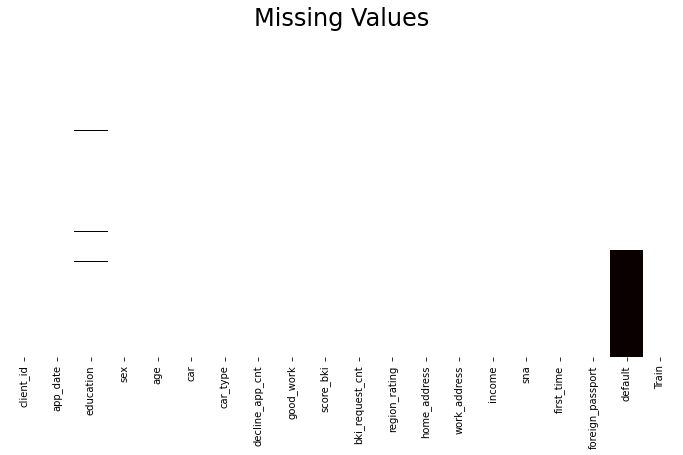

In [1024]:
fig = plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.isnull(), cbar=False, cmap='hot_r', yticklabels=[]).set_title('Missing Values', fontsize=24)

In [1025]:
print(df.isna().sum())

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту  

Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 5 бинарных, 6 категориальных и 7 числовых. Всего пропусков 478, все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезностей. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Т.к в признаке "education" пропусков немного, то заполним их наиболее часто встречающимся значением.

In [1026]:
train['education'].fillna(value=train['education'].mode()[0], inplace=True)
test['education'].fillna(value=test['education'].mode()[0], inplace=True)

In [1027]:
df = train.append(test, sort=False).reset_index(drop=True) # объединяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [1028]:
# внесем данные из резюме в списки 
# временной ряд
time_cols = ['app_date']
# бинарные переменные (default не включаем в список)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

# 4. Вспомогательные функции

In [1029]:
# Сохраним список всех палитр matplotlib
palette_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
                'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
                'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 
                'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
                'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
                'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 
                'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 
                'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 
                'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 
                'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 
                'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 
                'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 
                'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
                'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 
                'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 
                'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 
                'icefire_r', 'inferno', 'inferno_r', 'magma', 'magma_r', 'mako', 
                'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
                'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 
                'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 
                'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 
                'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
                'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [1030]:
# Для выбора случайных цветов сгенерируем список
colors = np.arange(0.2, 0.95, 0.05)

In [1031]:
# Функция для отрисовки гистограммы и boxplot-а числовых признаков
def draw_hist(parameter, dataset=df[df['Train'] == 1], target='default', bins=10):
    print(f"Гисторамма и boxplot признака {parameter}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=dataset, x=parameter, bins=bins, ax=ax[0], color=np.random.choice(colors, 3))
    sns.boxplot(data=dataset, ax=ax[1], x=target, y=parameter, palette=np.random.choice(palette_list))

In [1032]:
# Функция отличается от предыдущей тем, что строит график логарифмированных данных.
def draw_log_hist(parameter, dataset=df[df['Train'] == 1], target='default', bins=10):
    print(f"Гисторамма и boxplot логарифмированного признака {parameter}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=dataset, x=abs(np.log(dataset[parameter] + 1)), bins=bins, ax=ax[0], color=np.random.choice(colors, 3))
    sns.boxplot(data=dataset, y=abs(np.log(dataset[parameter] + 1)), ax=ax[1], x=target, palette=np.random.choice(palette_list))

In [1033]:
# Функция для построения графиков бинарных и категориальных признаков
def draw_count_plot(parameter, dataset=df[df['Train'] == 1], target='default'):
    counter = dataset[parameter].value_counts(normalize=True)    
    unique_values = dataset[parameter].unique()
    
    # Вспомогательная функция для определения доли неплательщиков в каждой категории
    def get_value():
        values = {}
        for number in range(len(unique_values)):
            value = len(dataset[(dataset[parameter] == unique_values[number]) & (dataset[target] == 1)])
            value_full = len(dataset[dataset[parameter] == unique_values[number]])
            attribute = str(round(((value / value_full) * 100), 2))
            values[number] = attribute
        return values
    
    values = get_value()
    
    print(f"Распределение целевой переменной {target} по признаку {parameter}.")
    fig = plt.plot(figsize=(12, 4))
    sns.countplot(data=dataset, x=parameter, hue=target, palette=np.random.choice(palette_list))
    print(f"Распределение признака в процентном соотношении")
    print(counter)
    print(f"Распределние признака в зависимости от целевой переменной")
    for value in range(len(unique_values)):
        print(f"Среди показателя {unique_values[value]} неплательщиков {values[value]}%")

In [1034]:
# Функция для определения выбросов
def detect_outliers(parameter, dataset=df[df['Train'] == 1], log=False):
    if log == True:
        variable = np.log(dataset[parameter] + 1)
    else:
        variable = dataset[parameter]
    perc25 = variable.quantile(0.25)
    perc75 = variable.quantile(0.75)
    IQR = perc75 - perc25
    left_border = perc25 - 1.5*IQR
    right_border = perc75 + 1.5*IQR
    outliers = len(variable[(variable < left_border) | (variable > right_border)])
    left_outliers = len(variable[(variable < left_border)])
    right_outliers = len(variable[(variable > right_border)])
        
    print(f'Рассчитано по логарифмированным значениям: {log}')
    print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}')
    print(f'IQR: {IQR}')
    print(f"Границы выбросов: [{left_border}; {right_border}]")
    print(f'Количество выбросов: {outliers}')
    print(f"Количество выбросов слева: {left_outliers}")
    print(f"Количество выбросов справа: {right_outliers}")

In [1035]:
# Функция для построения графика метрики ROC-AUC
def draw_roc_auc():
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [1036]:
# Функция для отрисовки cofusion matrix
def draw_cm():
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [1037]:
# Функция для показа метрик
def show_metrics():
    accuracy = accuracy_score(y_test, y_pred)
    print("Показатель метрики accuracy:")
    print(accuracy, '\n')
    
    precision = precision_score(y_test, y_pred)
    print("Показатель метрики precision:")
    print(precision, '\n')
    
    recall = recall_score(y_test, y_pred)
    print("Показатель метрики recall:")
    print(recall, '\n')
    
    f1 = f1_score(y_test, y_pred)
    print("Показатель метрики f1 score:")
    print(f1, '\n')
    
    return accuracy_score, precision_score, recall_score, f1_score    

In [1038]:
def create_dataset(ds):
    """Создание датасета в numpy формате"""
    
    # Стандартизация числовых переменных
    def standartize():
        x_num_train = StandardScaler().fit_transform(ds[ds['Train'] == 1][num_cols].values)
        x_num_test = StandardScaler().fit_transform(ds[ds['Train'] == 0][num_cols].values)
        return x_num_train, x_num_test
   
    # Применим метод OneHotEncoding для категориальных переменных
    def OHE():    
        x_cat_train = OneHotEncoder(sparse = False).fit_transform(ds[ds['Train'] == 1][cat_cols].values)
        x_cat_test = OneHotEncoder(sparse = False).fit_transform(ds[ds['Train'] == 0][cat_cols].values)
        return x_cat_train, x_cat_test
    
    # Сохраним бмнарные признаки в виде матрицы
    def to_matrix():        
        x_bin_train = ds[ds['Train'] == 1][bin_cols].values
        x_bin_test = ds[ds['Train'] == 0][bin_cols].values
        return x_bin_train, x_bin_test
    
    x_num_train, x_num_test = standartize()
    x_cat_train, x_cat_test = OHE()
    x_bin_train, x_bin_test = to_matrix()
    
    # Объединяем
    x = np.hstack([x_num_train, x_bin_train, x_cat_train])
    y = ds[ds['Train'] == 1]['default'].values
    # Сохраним тестовый датасет
    test = np.hstack([x_num_test, x_bin_test, x_cat_test])
    
    return x, y, test

# 5. Анализ переменных

### Анализ числовых переменных.

#### Age

In [1039]:
train['age'].describe()

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

Гисторамма и boxplot признака age


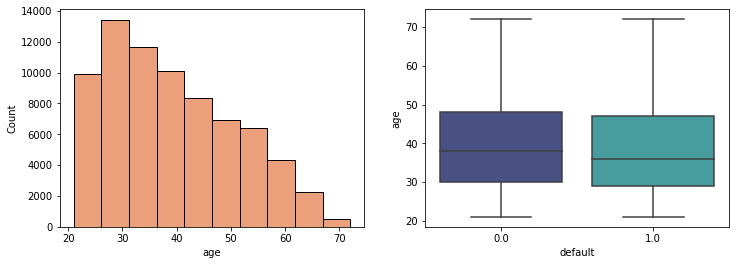

In [1040]:
draw_hist('age')

Гисторамма и boxplot логарифмированного признака age


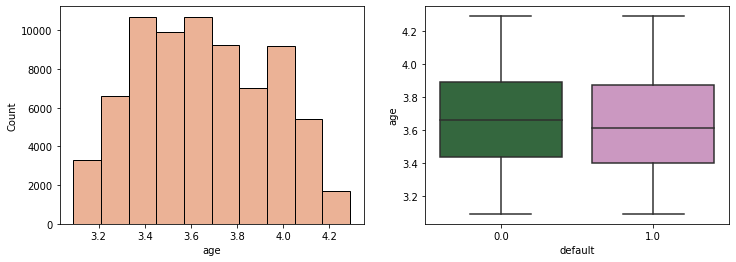

In [1041]:
draw_log_hist('age')

In [1042]:
# Распределение логнормальное. Выбросов нет. Изменим значение на логарифм.

In [1043]:
df['age'] = np.log(df['age'] + 1)

#### Decline_app_cnt

Гисторамма и boxplot признака decline_app_cnt


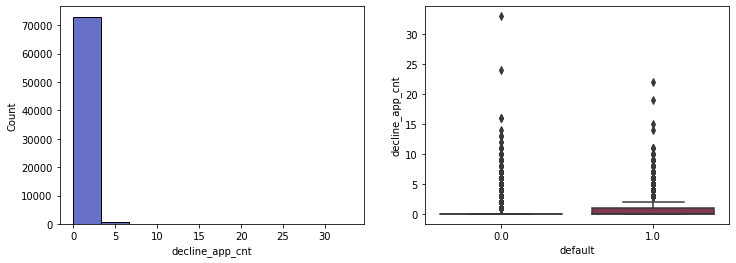

In [1044]:
draw_hist('decline_app_cnt')

In [1045]:
# Построим графики логарифмированной переменной

Гисторамма и boxplot логарифмированного признака decline_app_cnt


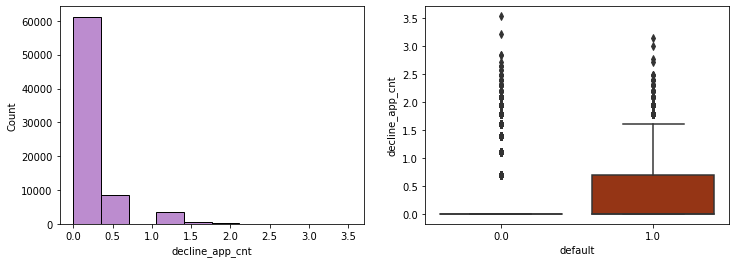

In [1046]:
draw_log_hist('decline_app_cnt')

In [1047]:
# Признак имеет большое количество выбросов. Определим границы выбросов.
detect_outliers('decline_app_cnt')

# Все значения выше нуля находятся за границей выбросов. Оставим все как есть.

Рассчитано по логарифмированным значениям: False
25-й перцентиль: 0.0, 75-й перцентиль: 0.0
IQR: 0.0
Границы выбросов: [0.0; 0.0]
Количество выбросов: 12585
Количество выбросов слева: 0
Количество выбросов справа: 12585


#### score_bki

Гисторамма и boxplot признака score_bki


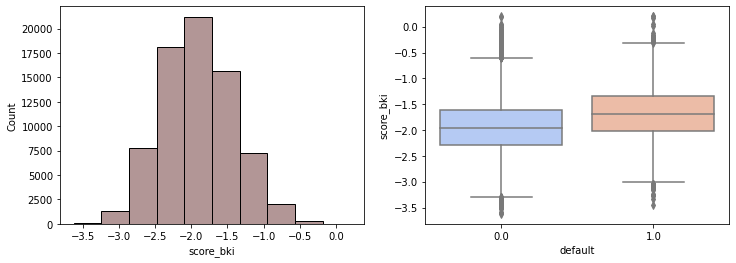

In [1048]:
draw_hist('score_bki')

In [1049]:
detect_outliers('score_bki')

Рассчитано по логарифмированным значениям: False
25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126
IQR: 0.6897025750000001
Границы выбросов: [-3.2940876975; -0.5352773974999998]
Количество выбросов: 351
Количество выбросов слева: 52
Количество выбросов справа: 299


In [1050]:
# Распределение параметра нормальное. Выбросов мало. Оставляем как есть.

#### Bki_request_cnt

Гисторамма и boxplot признака bki_request_cnt


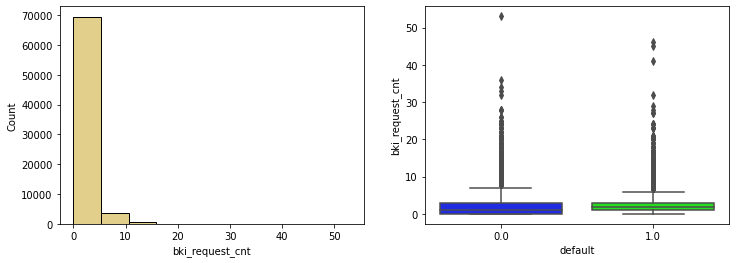

In [1051]:
draw_hist('bki_request_cnt')

Гисторамма и boxplot логарифмированного признака bki_request_cnt


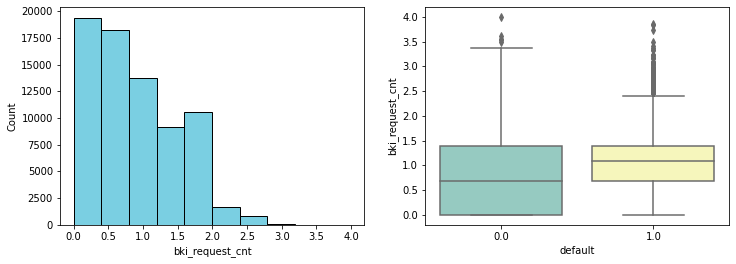

In [1052]:
draw_log_hist('bki_request_cnt')

In [1053]:
detect_outliers('bki_request_cnt', log=False)

Рассчитано по логарифмированным значениям: False
25-й перцентиль: 0.0, 75-й перцентиль: 3.0
IQR: 3.0
Границы выбросов: [-4.5; 7.5]
Количество выбросов: 1755
Количество выбросов слева: 0
Количество выбросов справа: 1755


In [1054]:
detect_outliers('bki_request_cnt', log=True)

Рассчитано по логарифмированным значениям: True
25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906
IQR: 1.3862943611198906
Границы выбросов: [-2.0794415416798357; 3.465735902799726]
Количество выбросов: 9
Количество выбросов слева: 0
Количество выбросов справа: 9


In [1055]:
# Распределение смещено вправо. При логарифмировании получилось всего 9 выбросов. Изменим значение на логарифм.

In [1056]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

#### Income

Гисторамма и boxplot признака income


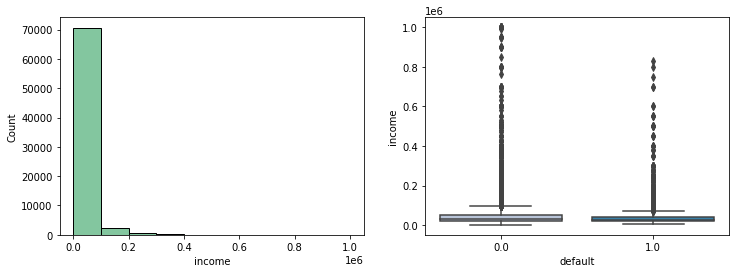

In [1057]:
draw_hist('income')

Гисторамма и boxplot логарифмированного признака income


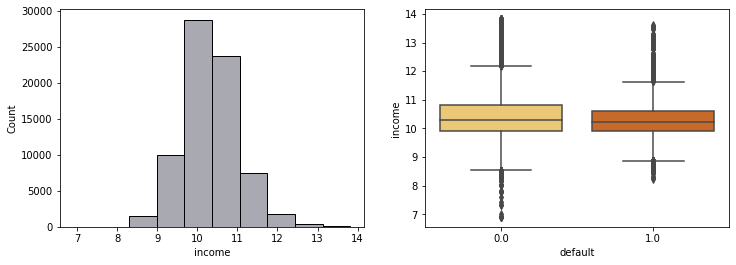

In [1058]:
draw_log_hist('income')

In [1059]:
detect_outliers('income', log=True)

Рассчитано по логарифмированным значениям: True
25-й перцентиль: 9.90353755128617, 75-й перцентиль: 10.778977123006351
IQR: 0.8754395717201806
Границы выбросов: [8.590378193705899; 12.092136480586621]
Количество выбросов: 1767
Количество выбросов слева: 595
Количество выбросов справа: 1172


In [1060]:
# Распределение логнормальное, выбросов немало, даже с логарифмом. 
# Пока оставим так.
# В модели будем использовать логарифм от признака.

In [1061]:
df['income'] = np.log(df['income'] + 1)

#### Определим значимость признаков с помощью теста ANOVA.

<AxesSubplot:>

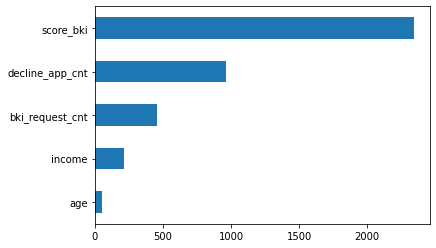

In [1062]:
imp_num = pd.Series(f_classif(df[df['Train'] == 1][num_cols], df[df['Train'] == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [1063]:
# Самым значимым оказался показатель кредитного рейтинга (что неудивительно).
# Следом идет показатель количества отказов.

### Анализ бинарных признаков.

In [1064]:
# Взглянем на признаки более подробно. 

#### Sex

Распределение целевой переменной default по признаку sex.
Распределение признака в процентном соотношении
F    0.563178
M    0.436822
Name: sex, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя M неплательщиков 13.44%
Среди показателя F неплательщиков 12.12%


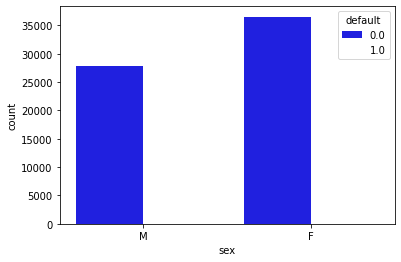

In [1065]:
draw_count_plot('sex')

#### Car

Распределение целевой переменной default по признаку car.
Распределение признака в процентном соотношении
N    0.67524
Y    0.32476
Name: car, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя Y неплательщиков 10.63%
Среди показателя N неплательщиков 13.7%


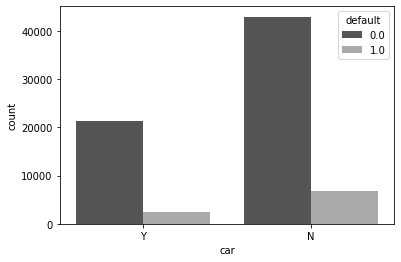

In [1066]:
draw_count_plot('car')

#### Car_type

Распределение целевой переменной default по признаку car_type.
Распределение признака в процентном соотношении
N    0.810187
Y    0.189813
Name: car_type, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя Y неплательщиков 8.75%
Среди показателя N неплательщиков 13.63%


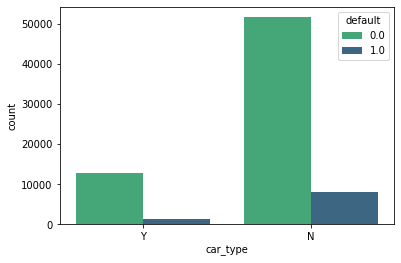

In [1067]:
draw_count_plot('car_type')

#### Good_work

Распределение целевой переменной default по признаку good_work.
Распределение признака в процентном соотношении
0    0.835106
1    0.164894
Name: good_work, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 0 неплательщиков 13.34%
Среди показателя 1 неплательщиков 9.45%


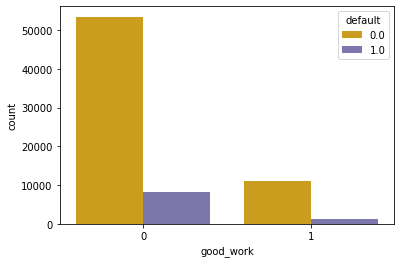

In [1068]:
draw_count_plot('good_work')
# 1 - значит "Yes"
# 0 - "No"

#### Foreign_passport

Распределение целевой переменной default по признаку foreign_passport.
Распределение признака в процентном соотношении
N    0.850052
Y    0.149948
Name: foreign_passport, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя N неплательщиков 13.63%
Среди показателя Y неплательщиков 7.41%


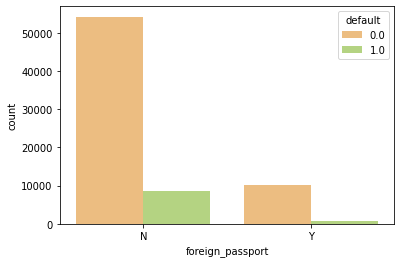

In [1069]:
draw_count_plot('foreign_passport')

#### Преобразование

In [1070]:
# Преобразуем строковые данные в числовые с помощью LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    print(column)
    print(dict(enumerate(label_encoder.classes_)), "\n")

sex
{0: 'F', 1: 'M'} 

car
{0: 'N', 1: 'Y'} 

car_type
{0: 'N', 1: 'Y'} 

good_work
{0: 0, 1: 1} 

foreign_passport
{0: 'N', 1: 'Y'} 



In [1071]:
# Убедимся в преобразовании
df[bin_cols]

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1
...,...,...,...,...,...
110143,0,0,0,0,0
110144,0,1,1,0,0
110145,1,0,0,0,0
110146,0,0,0,0,0


### Анализ категориальных признаков

#### Education

Распределение целевой переменной default по признаку education.
Распределение признака в процентном соотношении
SCH    0.530725
GRD    0.316603
UGR    0.133010
PGR    0.017033
ACD    0.002629
Name: education, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя SCH неплательщиков 15.03%
Среди показателя GRD неплательщиков 9.01%
Среди показателя UGR неплательщиков 13.15%
Среди показателя PGR неплательщиков 6.44%
Среди показателя ACD неплательщиков 4.12%


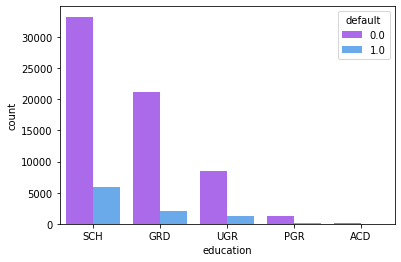

In [1072]:
draw_count_plot('education')

In [1073]:
# Заменим значения на числовые.
education = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
df.education = list(map(lambda x: education[x], df['education']))

#### Region rating

Распределение целевой переменной default по признаку region_rating.
Распределение признака в процентном соотношении
50    0.372945
60    0.217821
40    0.162970
80    0.155409
70    0.083998
30    0.004065
20    0.002791
Name: region_rating, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 50 неплательщиков 13.61%
Среди показателя 80 неплательщиков 7.32%
Среди показателя 60 неплательщиков 12.88%
Среди показателя 40 неплательщиков 16.97%
Среди показателя 70 неплательщиков 9.24%
Среди показателя 20 неплательщиков 21.36%
Среди показателя 30 неплательщиков 19.0%


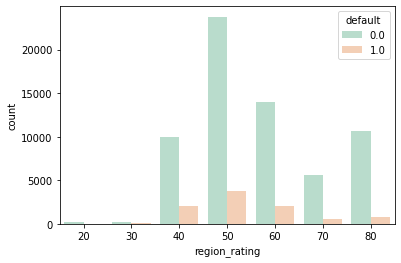

In [1074]:
draw_count_plot('region_rating')

#### Home address

Распределение целевой переменной default по признаку home_address.
Распределение признака в процентном соотношении
2    0.541417
1    0.441537
3    0.017046
Name: home_address, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 1 неплательщиков 9.29%
Среди показателя 2 неплательщиков 15.51%
Среди показателя 3 неплательщиков 11.61%


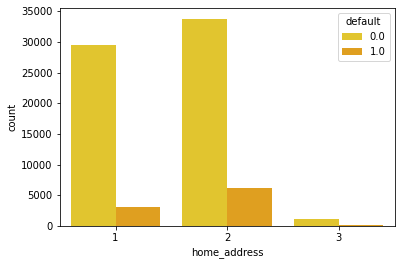

In [1075]:
draw_count_plot('home_address')

#### Work address

Распределение целевой переменной default по признаку work_address.
Распределение признака в процентном соотношении
3    0.609209
2    0.277863
1    0.112928
Name: work_address, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 2 неплательщиков 10.25%
Среди показателя 3 неплательщиков 14.8%
Среди показателя 1 неплательщиков 7.42%


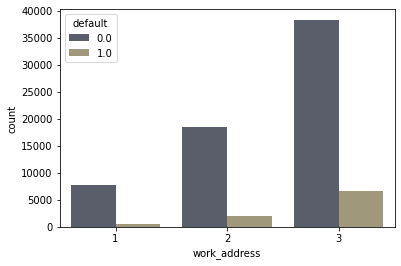

In [1076]:
draw_count_plot('work_address')

#### Sna

Распределение целевой переменной default по признаку sna.
Распределение признака в процентном соотношении
1    0.640944
4    0.159203
2    0.143986
3    0.055868
Name: sna, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 4 неплательщиков 21.15%
Среди показателя 1 неплательщиков 9.82%
Среди показателя 2 неплательщиков 14.98%
Среди показателя 3 неплательщиков 15.77%


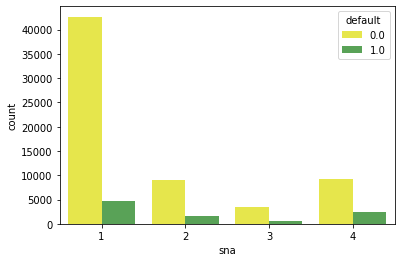

In [1077]:
draw_count_plot('sna')

#### First time

Распределение целевой переменной default по признаку first_time.
Распределение признака в процентном соотношении
3    0.423515
4    0.253892
1    0.165842
2    0.156750
Name: first_time, dtype: float64
Распределние признака в зависимости от целевой переменной
Среди показателя 1 неплательщиков 18.61%
Среди показателя 4 неплательщиков 8.2%
Среди показателя 3 неплательщиков 12.03%
Среди показателя 2 неплательщиков 15.54%


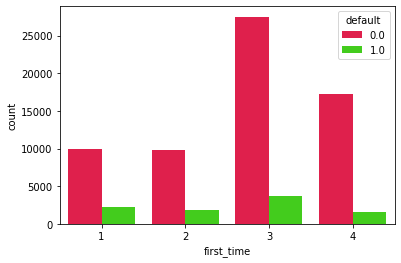

In [1078]:
draw_count_plot('first_time')

#### Определим значимость бинарных и категориальных признаков

<AxesSubplot:>

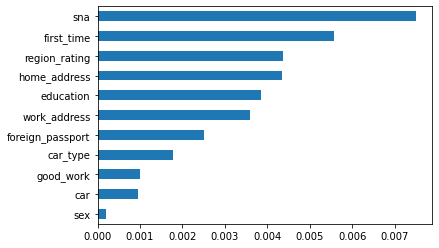

In [1079]:
imp_cat = pd.Series(mutual_info_classif(df[df['Train'] == 1][bin_cols + cat_cols], df[df['Train'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Корреляционный анализ

<AxesSubplot:>

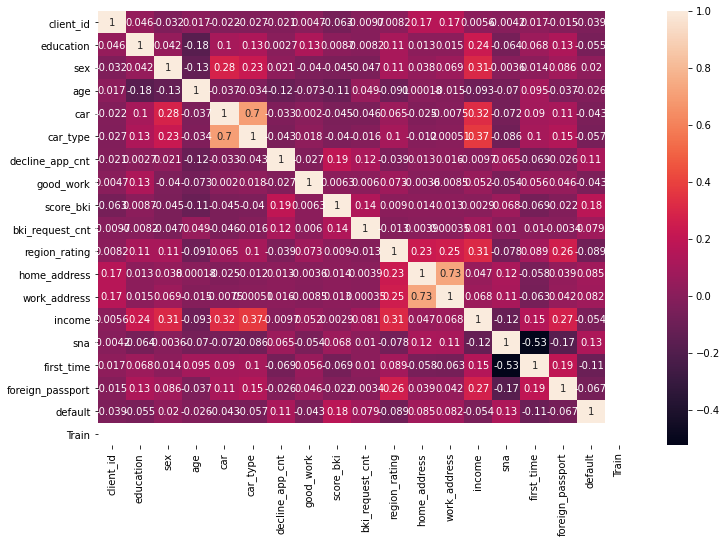

In [1080]:
plt.subplots(figsize = (12, 8))
sns.heatmap(df[df['Train'] == 1].corr(), annot = True)

Сильно скоррелированными оказались признаки 'car' и 'car_type', а также 'work_address' и 'home_address'.  
Оставим признаки 'car_type' и 'home_address', т.к они имеют большую значимость для целевой переменной.  

# 5. Подготовка модели к обучению

In [1081]:
df.drop(['car', 'work_address'], axis=1, inplace=True)

In [1082]:
# Показатель sex оказался малозначимым, также уберем его
#df.drop(['sex'], axis=1, inplace=True)
# Стало только хуже

In [1083]:
# Перезапишем переменные cat_cols и bin_cols
cat_cols = ['education', 'region_rating', 'home_address', 'sna', 'first_time']
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']

In [1084]:
# Удалим нечисловой признак app_date.
df.drop(['app_date'], axis=1, inplace=True)

In [1085]:
# Заменим показатель region rating на группы
def change_region_rating(row):
    if row == 20 or row == 30:
        return 0
    elif row == 40:
        return 1
    elif row == 50 or row == 60:
        return 2
    else:
        return 3

#df['region_rating'] = df['region_rating'].apply(change_region_rating)
# Стало хуже

In [1086]:
x, y, test = create_dataset(df)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RANDOM_SEED)

# 6. Создание модели

In [1087]:
model = LogisticRegression()
model.fit(x, y)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)
y_pred_proba = y_pred_proba[:,1]

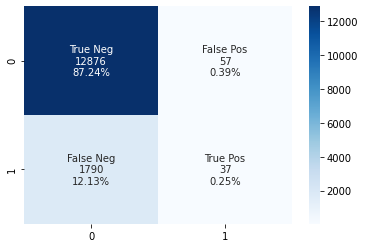

In [1088]:
draw_cm()

In [1089]:
show_metrics()

Показатель метрики accuracy:
0.8748644986449865 

Показатель метрики precision:
0.39361702127659576 

Показатель метрики recall:
0.020251778872468526 

Показатель метрики f1 score:
0.03852160333159812 



(<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

Модель со стандартными параметрами показывает очень низкий показатель recall.  
Также, практически никогда не угадываем дефолтных клиентов.  

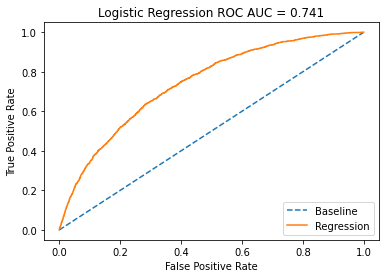

In [1090]:
draw_roc_auc()

На данном этапе показатель ROC-AUC на тренировочных данных составляет 0,740.  

Данные несбалансированы. Увеличим число записей с дефолтами.  
Посмотрим что получилось.

In [1091]:
x, y, test = create_dataset(df)

In [1092]:
# Используем инструмент RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=1)
x, y = oversample.fit_resample(x, y)

In [1093]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RANDOM_SEED)

In [1094]:
model = LogisticRegression()
model.fit(x, y)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)
y_pred_proba = y_pred_proba[:,1]

In [1095]:
show_metrics()

Показатель метрики accuracy:
0.6677660936711808 

Показатель метрики precision:
0.6685603112840467 

Показатель метрики recall:
0.6662788894059253 

Показатель метрики f1 score:
0.6674176507147297 



(<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

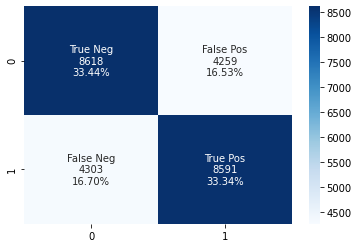

In [1096]:
draw_cm()

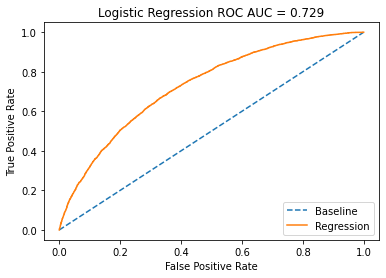

In [1097]:
draw_roc_auc()

Метрика accuracy уменьшилась, как и roc-auc.  
Все остальные подросли.  
Итоговый результат стал лучше.

Подберем оптимальные гиперпараметры

In [1098]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Выбор алгоритма
#solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# Оптимальным оказался алгоритм по умолчанию 'lbfgs'

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


Показатель метрики accuracy:
0.6683481432618059 

Показатель метрики precision:
0.6692098092643052 

Показатель метрики recall:
0.6666666666666666 

Показатель метрики f1 score:
0.6679358172423171 



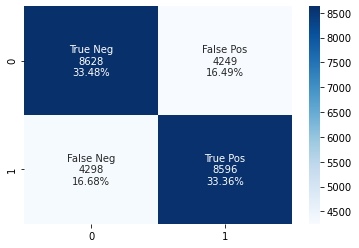

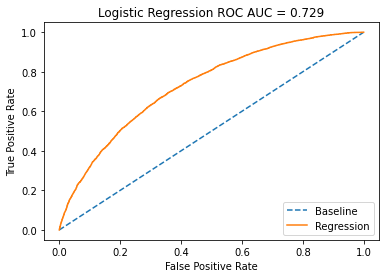

In [1107]:
# Создадим новую модель, используя оптимальные параметры
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RANDOM_SEED)
model = LogisticRegression(C=1, penalty='l2')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)
y_pred_proba = y_pred_proba[:,1]

show_metrics()
draw_cm()
draw_roc_auc()

In [1105]:
# Предскажем результат на тестовых данных
model = LogisticRegression(C=1, penalty='l2')
model.fit(x, y)
y_pred = model.predict_proba(test)
y_pred = y_pred[:,1]

# 7. Submission

In [1101]:
sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [1102]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [1106]:
# Сохраним client_id из тестовых данных в отдельную переменную
clients = pd.DataFrame(df[df['Train'] == 0]['client_id'])
# Сохраним submission в файл
submit = clients
submit['default'] = y_pred
submit.to_csv('submission.csv', index=False)

In [1104]:
submit

,client_id,default
73799,74835,0.215674
73800,17527,0.794214
73801,75683,0.321681
73802,26883,0.375335
73803,28862,0.128068
...,...,...
110143,83775,0.774665
110144,106254,0.133535
110145,81852,0.791762
110146,1971,0.554308
